# Dependencies

In [1]:
import argparse

import os

import time
import torch

import matplotlib.pyplot as plt
import numpy as np

from model.dataloader import HELMETDataLoader
from model.dataloader import class_dict
from model.models import Darknet, load_weights, load_darknet_weights
from utils.utils import *

from IPython.display import clear_output

# Load in model

In [2]:
cfg_path = './cfg/yolov3_36.cfg'
weights_path = './weights/darknet53.conv.74'

In [3]:
### 

# Load in convolutional darknet.
# TODO: Set a default img_size for convenience.
def get_darknet(img_size, cfg=cfg_path):
    return Darknet(cfg, img_size)

img_size = 416

model = get_darknet(img_size=img_size)

# Load in weights
load_darknet_weights(model, weights_path)

# Dataloader

In [4]:
batch_size = 3

dataloader = HELMETDataLoader("./data/HELMET_DATASET_DUMMY", shuffle=True, batch_size=batch_size, resize=(img_size, img_size))

# Dataloader unit test

In [5]:
batch = next(iter(dataloader))

imgs, targets, annotations = batch

print('Image shape:', imgs[0].shape)

out = model(imgs[0].reshape(1, 3, img_size, img_size))

print('Output shape:', out.shape)
print('Targets shape:', targets[0].size())

Image shape: torch.Size([3, 416, 416])
Output shape: torch.Size([1, 10647, 41])
Targets shape: torch.Size([5, 5])


In [6]:
imgs[0].reshape(1, 3, img_size, img_size).shape

torch.Size([1, 3, 416, 416])

# Detection "unit test"

In [7]:
# cuda = torch.cuda.is_available()
device = 'cpu' # device = torch.device('cuda:0' if cuda else 'cpu')

In [30]:
opt = {'conf_thres': .5, 
       'nms_thres': .45
      }

In [9]:
# os.system('rm -rf ' + opt.output_folder)
# os.makedirs(opt.output_folder, exist_ok=True)

model.to(device).eval()

# Set Dataloader
# classes = load_classes(opt.class_path)  # Extracts class labels from file
# dataloader = load_images(opt.image_folder, batch_size=opt.batch_size, img_size=opt.img_size)

imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index
# for batch_i, (img_paths, img) in enumerate(dataloader):
#     print(batch_i, img.shape, end=' ')

batch = next(iter(dataloader))

batch_imgs, batch_targets, batch_annotations = batch

# Get detections
with torch.no_grad():
    # chip = torch.from_numpy(img).unsqueeze(0).to(device)
    pred = model(batch_imgs[0].reshape(1, 3, img_size, img_size)) # pred = model(chip)
    pred = pred[pred[:, :, 4] > opt['conf_thres']]

    if len(pred) > 0:
        detections = non_max_suppression(pred.unsqueeze(0), opt['conf_thres'], opt['nms_thres'])
        img_detections.extend(detections)
        # imgs.extend(img_paths)

In [10]:
img_detections

[None]

(-0.5, 415.5, 415.5, -0.5)

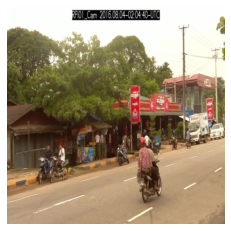

In [11]:
plt.imshow(np.array(batch_imgs[0]).transpose([1, 2, 0]))
plt.axis('off')

In [12]:
# Bugfix :D
# model.to(device).train()
# train_batch = torch.rand((3, 3, 832, 832))
# targets = [ torch.tensor([[1, .5, .5, .2, .2], [1, .4, .4, .2, .2]]) ,  torch.tensor([[1, .5, .5, .2, .2]]) , torch.tensor([]) ]
# model(train_batch, targets, requestPrecision=True)

# Training loop

In [13]:
CUTOFF = 155
# Transfer learning (train only YOLO layers)
for i, (name, p) in enumerate(model.named_parameters()):
    # print(i, p.shape[0], name)
    # if p.shape[0] != 650:  # not YOLO layer
    #    p.requires_grad = False
    if i > CUTOFF:
        p.requires_grad = False

In [19]:
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3,
    momentum=.9, weight_decay=5e-4, nesterov=True
)

Get device.

In [15]:
cuda_enable = True
cuda_available = torch.cuda.is_available()
if cuda_enable and cuda_available:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Using device: ', device)

Using device:  cuda:0


Train loop.

In [27]:
N_ITERATIONS = 1000
PLOT_EVERY = 1

model.to(device)

plot_dict = {'train_loss': [], 'train_acc': [], 'Iteration': []}

# imgs, targets, annotations = next(iter(dataloader))
# targets = list(map(lambda x: x.type(torch.FloatTensor), targets)) # To correct type.

for epoch in range(1, N_ITERATIONS + 1):
    since = time.time()
    
    imgs, targets, annotations = next(iter(dataloader))
    targets = list(map(lambda x: x.type(torch.FloatTensor), targets)) # To correct type.
    
    # Train
    model.train()
    optimizer.zero_grad() # Zero gradients
    loss = model(imgs.to(device), targets, requestPrecision=False)
    loss.backward()
    optimizer.step()
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    if not (epoch - 1) % PLOT_EVERY:
        plot_dict['Iteration'].append(epoch)
        plot_dict['train_loss'].append(loss.cpu().detach().numpy())
        # plot_dict['train_acc'].append(1-trn_err)
        fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
        ax.plot(plot_dict['Iteration'], plot_dict['train_loss'])
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
        # axs[1].plot(plot_dict['Epoch'], plot_dict['train_acc'])
        # axs[1].set_xlabel('Epochs')
        # axs[1].set_ylabel('Accuracy')
        plt.show()
    clear_output(wait=True)


Train Time 0m 0s


KeyboardInterrupt: 

<Figure size 540x360 with 0 Axes>

In [31]:
imgs, targets, annotations = next(iter(dataloader))
targets = list(map(lambda x: x.type(torch.FloatTensor), targets))

model.to(device).eval()
img_detections = []

# Get detections
for img in imgs:
    with torch.no_grad():
        pred = model(img.to(device).reshape(1, 3, img_size, img_size)) # pred = model(chip)
        pred = pred[pred[:, :, 4] > opt['conf_thres']]

        if len(pred) > 0:
            detections = non_max_suppression(pred.unsqueeze(0), opt['conf_thres'], opt['nms_thres'])
            img_detections.extend(detections)

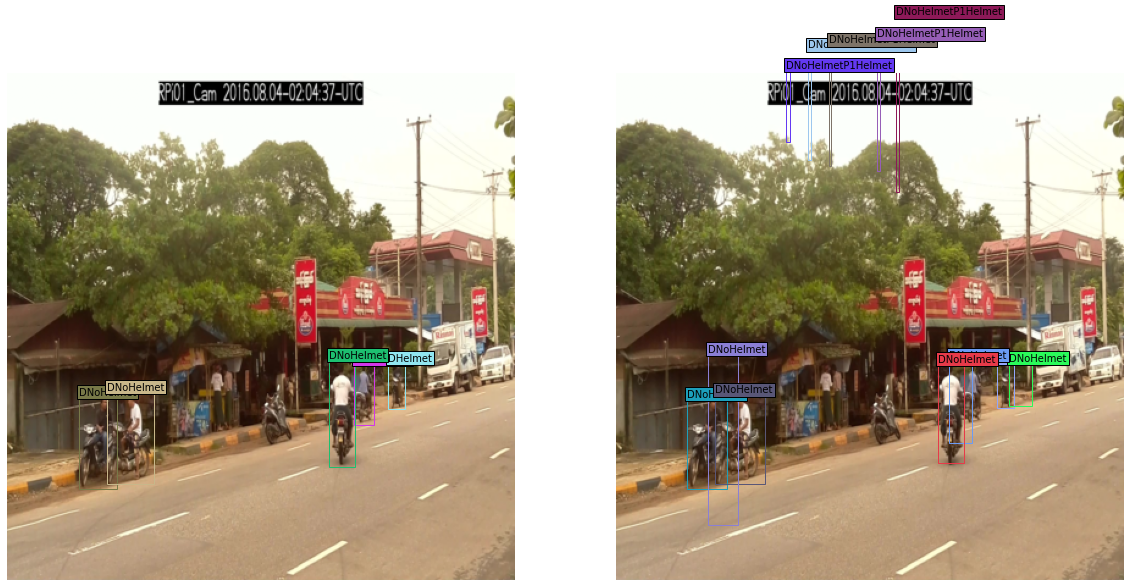

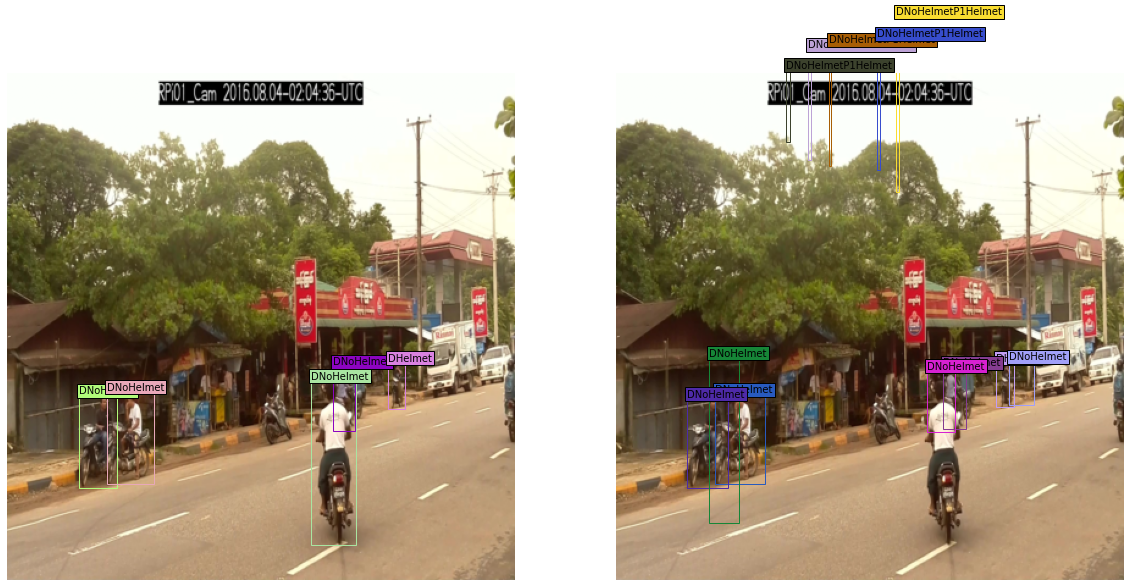

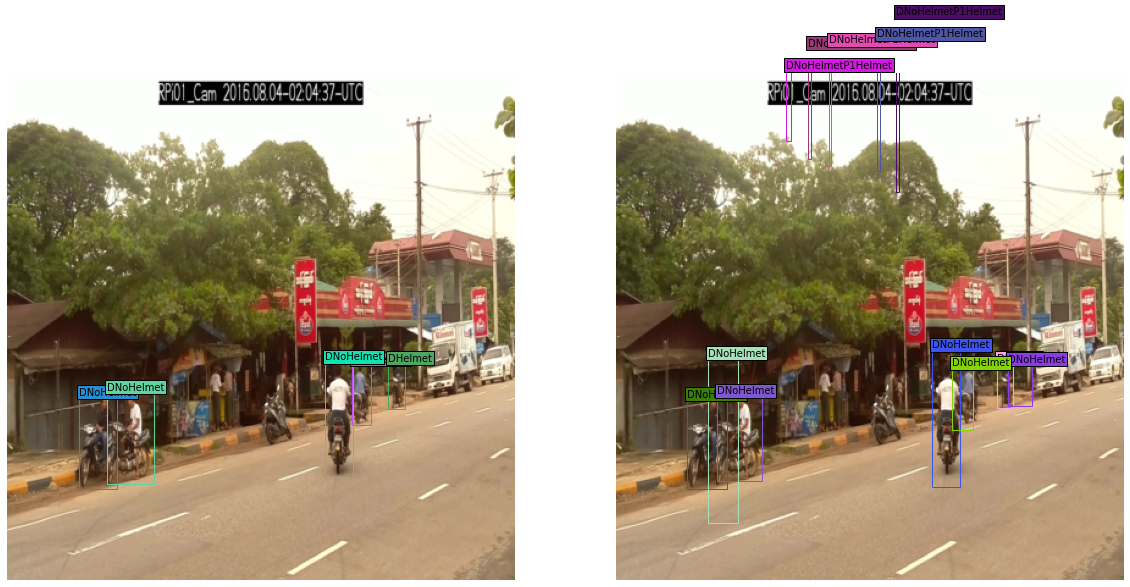

In [32]:
# detection = img_detectionn
# target = targets

for img, target, detection in zip(imgs, targets, img_detections):
    ### This is probably redundant in our case.
    # The amount of padding that was added
    pad_x = max(img.shape[1] - img.shape[2], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[2] - img.shape[1], 0) * (img_size / max(img.shape))
    # Image height and width after padding is removed
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(np.array(img).transpose([1, 2, 0]))
    ax2.imshow(np.array(img).transpose([1, 2, 0]))
    ax1.axis('off')
    ax2.axis('off')

    for label, x1, y1, box_w, box_h in target:
        # Rescale coordinates to original dimensions
        box_h = (box_h * img.shape[1]).item()
        box_w = (box_w * img.shape[2]).item()
        y1 = (y1 * img.shape[1] - box_h / 2).round().item()
        x1 = (x1 * img.shape[2] - box_w / 2).round().item()

        x1, y1 = max(x1, 0), max(y1, 0)

        label = list(class_dict.keys())[int(label)]
        col = tuple(np.random.random(3))
        rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
        ax1.add_patch(rect)
        ax1.text(x1, y1, label, fontsize=10, bbox={'facecolor': col, 'pad': 2})
    
    # Draw bounding boxes and labels of detections
    if detection is not None:
        unique_classes = detection[:, -1].cpu().unique()

        for i in unique_classes:
            n = (detection[:, -1].cpu() == i).sum()
            # print('%g %ss' % (n, classes[int(i)]))

        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detection:
            if len(class_dict.keys()) < int(cls_pred) - 1:
                continue

            # Rescale coordinates to original dimensions
            box_h = ((y2 - y1) / unpad_h) * img.shape[1]
            box_w = ((x2 - x1) / unpad_w) * img.shape[2]
            y1 = (((y1 - pad_y // 2) / unpad_h) * img.shape[1]).round().item()
            x1 = (((x1 - pad_x // 2) / unpad_w) * img.shape[2]).round().item()

            label = list(class_dict.keys())[int(cls_pred)]
            col = tuple(np.random.random(3))
            rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
            ax2.add_patch(rect)
            ax2.text(x1, y1, label, fontsize=10, bbox={'facecolor': col, 'pad': 2})

    plt.show()